<a href="https://colab.research.google.com/github/akansha935/Book-Recommender-System/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROBLEM STATEMENT

Financial fraud, especially credit card fraud, has become a major challenge for banks, e-commerce platforms, and financial institutions worldwide. With millions of transactions processed daily, detecting fraudulent activities in real time is crucial to prevent financial losses and protect customers.

The challenge lies in the fact that fraudulent transactions are very rare compared to legitimate ones (highly imbalanced data). Traditional rule-based systems often fail because fraudsters constantly adapt their strategies.

Objective:
To build a machine learning model that can accurately classify transactions as fraudulent or legitimate, minimizing false positives (flagging genuine transactions as fraud) while maximizing true fraud detection.

Key Questions:

Can we identify patterns in transaction data that distinguish fraudulent activities from normal ones?

How do we handle the class imbalance problem (fraud cases << non-fraud cases)?

Which algorithms (Logistic Regression, Random Forest, XGBoost, Neural Networks) perform best in detecting fraud?

What evaluation metrics (Precision, Recall, F1-score, ROC-AUC) are most appropriate for this problem?

Business Value:

Reduce financial losses due to fraud.

Improve customer trust and security.

Enable proactive fraud prevention strategies.


**Key Features in the Fraud Detection Dataset**
1. Type

The type of transaction (e.g., CASH-IN, CASH-OUT, TRANSFER, DEBIT, PAYMENT).

Some transaction types (like CASH-OUT and TRANSFER) are more prone to fraud.

2. Amount

The transaction amount in local currency.

Fraudulent transactions are often unusually large compared to the user’s history.

3. NameOrig

ID of the customer initiating the transaction (sender).

Helps track user behavior over multiple transactions.

4. oldbalanceOrg

The account balance of the sender before the transaction.

5. newbalanceOrig

The account balance of the sender after the transaction.

(Expected: oldbalanceOrg – amount = newbalanceOrig if legitimate).

A mismatch may indicate fraud.

6. nameDest

ID of the recipient (receiver).

Useful to detect if money is being sent to known fraud accounts.

7. oldbalanceDest

The recipient’s account balance before the transaction.

8. newbalanceDest

The recipient’s account balance after the transaction.

(Expected: oldbalanceDest + amount = newbalanceDest).

If balance doesn’t update properly, may indicate fraud.

9. isFraud (Target Variable ✅)

1 → Transaction is fraudulent.

0 → Legitimate transaction.

This is what we want to predict using ML.

10. isFlaggedFraud

1 → System flagged the transaction as suspicious (rule-based system).

0 → Not flagged.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style = "whitegrid")

In [ ]:
df = pd.read_csv("fraud.csv")

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69858 entries, 0 to 69857
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            69858 non-null  int64  
 1   type            69858 non-null  object 
 2   amount          69858 non-null  float64
 3   nameOrig        69858 non-null  object 
 4   oldbalanceOrg   69858 non-null  float64
 5   newbalanceOrig  69858 non-null  float64
 6   nameDest        69858 non-null  object 
 7   oldbalanceDest  69858 non-null  float64
 8   newbalanceDest  69857 non-null  float64
 9   isFraud         69857 non-null  float64
 10  isFlaggedFraud  69857 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 5.9+ MB


In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,1
isFraud,1


In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0.0,28212
1.0,84


In [ ]:
df["isFlaggedFraud"].value_counts()

,count
isFlaggedFraud,
0.0,28296


In [ ]:
df.shape[0]

28297

In [ ]:
 round((df['isFraud'].value_counts()[1] / df.shape[0]) * 100,2)

np.float64(0.3)

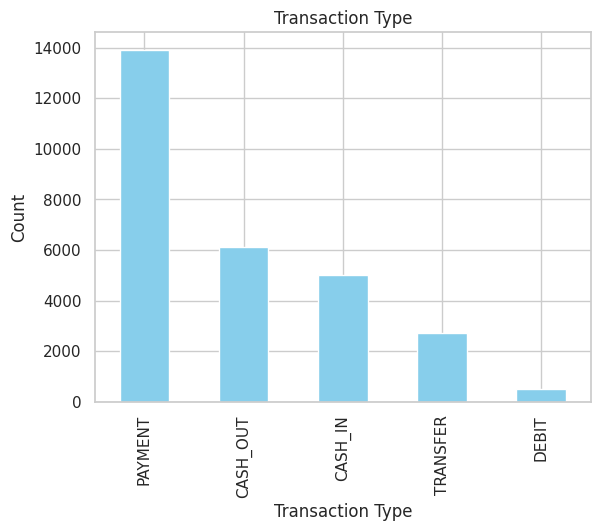

In [ ]:
df["type"].value_counts().plot(kind = "bar", title = "Transaction Type" , color = "skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

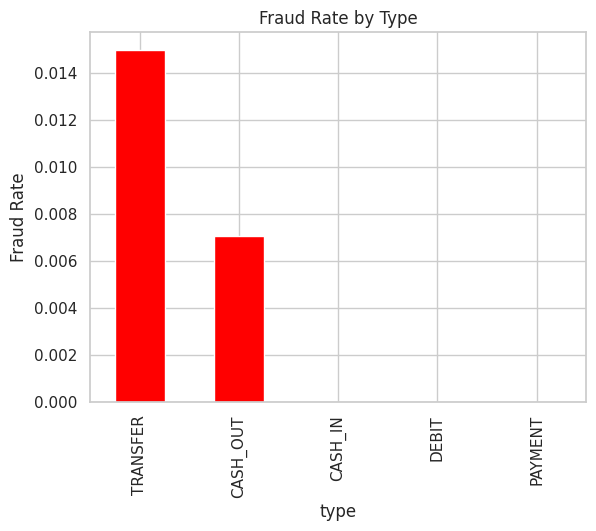

In [ ]:
fraud_by_type = df.groupby(["type"])["isFraud"].mean().sort_values(ascending = False)
fraud_by_type.plot(kind = "bar" , title = "Fraud Rate by Type", color = "red")
plt.ylabel("Fraud Rate")
plt.show()

In [ ]:
fraud_by_type

,isFraud
type,
TRANSFER,0.014991
CASH_OUT,0.007040
CASH_IN,0.000000
DEBIT,0.000000
PAYMENT,0.000000


In [ ]:
df["amount"].describe().astype(int)

,amount
count,28297
mean,135740
std,301316
min,1
25%,5966
50%,19506
75%,160102
max,10000000


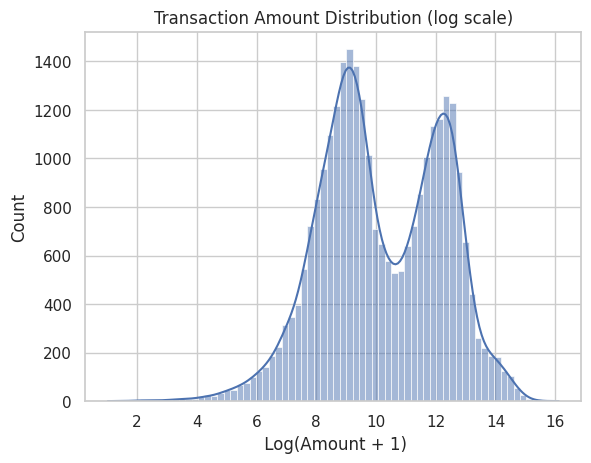

In [ ]:
sns.histplot(np.log1p(df["amount"]), kde = True)
plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel(" Log(Amount + 1)")
plt.show()

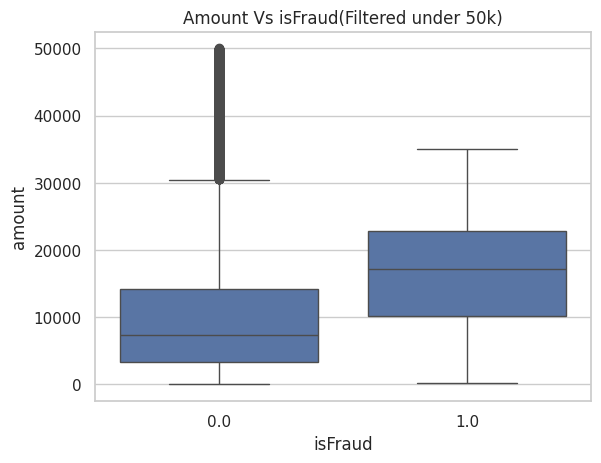

In [ ]:
sns.boxplot(data= df[df['amount'] < 50000] , x = "isFraud" , y= "amount")
plt.title("Amount Vs isFraud(Filtered under 50k)")
plt.show()

In [ ]:
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["oldbalanceDest"] - df["newbalanceDest"]

In [ ]:
(df["balanceDiffOrig"] < 0).sum()

np.int64(5002)

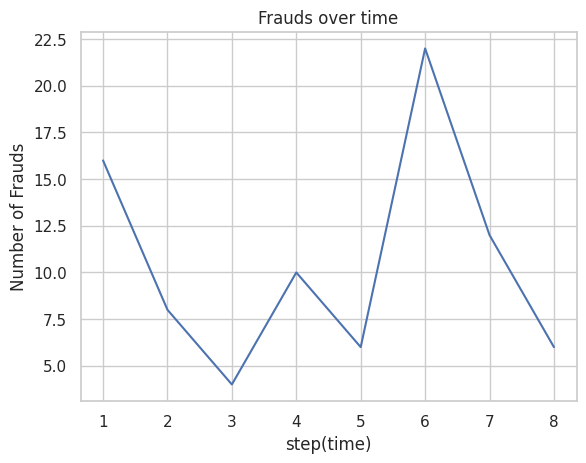

In [ ]:
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()
plt.plot(frauds_per_step.index , frauds_per_step.values , label = "Frauds per steps")
plt.xlabel("step(time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds over time")
plt.grid(True)
plt.show()

In [ ]:
 df.drop(columns = "step" , inplace=True) # This line was commented out to prevent dropping the column

In [ ]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [ ]:
top_senders = df["nameOrig"].value_counts().head(10)
top_receivers = df["nameDest"].value_counts().head(10)

In [ ]:
top_senders

,count
nameOrig,
C1612091270,1
C1231006815,1
C1666544295,1
C1305486145,1
C840083671,1
C2048537720,1
C90045638,1
C154988899,1
C1912850431,1


In [ ]:
top_receivers

,count
nameDest,
C985934102,71
C1286084959,60
C1590550415,59
C2083562754,58
C248609774,57
C977993101,56
C1360767589,54
C451111351,52
C665576141,51


In [ ]:
fraud_users = df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10)

In [ ]:
fraud_users

,count
nameOrig,
C1305486145,1
C840083671,1
C1420196421,1
C2101527076,1
C137533655,1
C1118430673,1
C749981943,1
C1334405552,1
C467632528,1


In [ ]:
fraud_types = df[df["type"].isin(["TRANSFER", "CASH_OUT"])]

In [ ]:
fraud_types["type"].value_counts()

,count
type,
CASH_OUT,6109
TRANSFER,2735


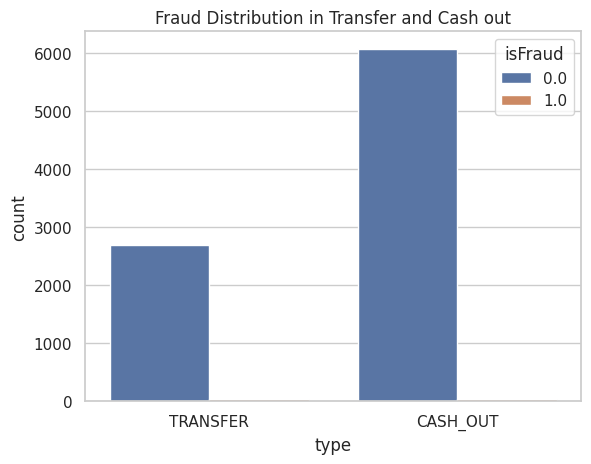

In [ ]:
sns.countplot(data = fraud_types , x = "type" , hue= "isFraud")
plt.title("Fraud Distribution in Transfer and Cash out")
plt.show()


In [ ]:
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest" , "isFraud"]].corr()

In [ ]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,0.037240,0.022199,0.320886,0.428226,0.081981
oldbalanceOrg,0.037240,1.000000,0.997933,0.144482,0.109220,-0.004231
newbalanceOrig,0.022199,0.997933,1.000000,0.148964,0.110361,-0.018826
oldbalanceDest,0.320886,0.144482,0.148964,1.000000,0.918069,-0.013884
newbalanceDest,0.428226,0.109220,0.110361,0.918069,1.000000,-0.008683
isFraud,0.081981,-0.004231,-0.018826,-0.013884,-0.008683,1.000000


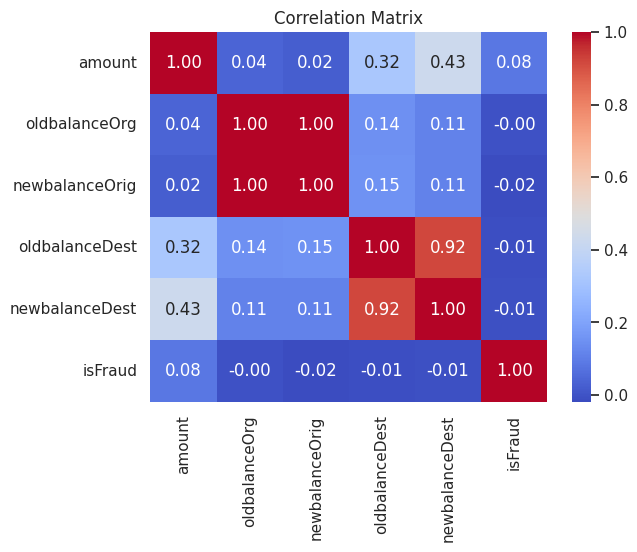

In [ ]:
sns.heatmap(corr,annot= True , cmap = "coolwarm" , fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
zero_after_transfer = df[
  (df["oldbalanceOrg"]> 0 )&
  (df["newbalanceOrig"] == 0) &
  (df["type"].isin(["TRANSFER", "CASH_OUT"]))

]

In [ ]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1.0,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1.0,0.0
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0.0,0.0
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0.0,0.0
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0.0,0.0


In [ ]:
df["isFraud"].value_counts()

,count
isFraud,
0.0,28212
1.0,84


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn. preprocessing import StandardScaler
from sklearn. linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df_model = df.drop(["nameOrig","nameDest","isFlaggedFraud"],axis= 1)

In [ ]:
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0.0


In [ ]:
categorical = ["type"]
numeric = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

In [ ]:
y = df_model["isFraud"]
x = df_model.drop("isFraud",axis=1)

In [ ]:
df_model.dropna(subset = ["isFraud"] , inplace = True)
y = df_model["isFraud"]
x = df_model.drop("isFraud",axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop="first"), categorical)
    ],
    remainder= "drop"

    )

In [ ]:
Pipeline = Pipeline([
    ("prep",preprocessor),
    ("clf",LogisticRegression(class_weight="balanced",max_iter = 1000))

])

In [ ]:
Pipeline.fit(x_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
 y_pred = Pipeline.predict(x_test)

In [ ]:
 print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93      8464
         1.0       0.02      0.92      0.04        25

    accuracy                           0.86      8489
   macro avg       0.51      0.89      0.48      8489
weighted avg       1.00      0.86      0.92      8489



In [ ]:
confusion_matrix(y_test,y_pred)

array([[7302, 1162],
       [   2,   23]])

In [ ]:
Pipeline.score(x_test,y_test)

0.8628813758982212

In [ ]:
import joblib
joblib.dump(Pipeline,"fraud_detection_Pipeline.pkl")

['fraud_detection_Pipeline.pkl']

In [ ]:
%pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.3 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import joblib

model = joblib.load("fraud_detection_Pipeline.pkl")
st.title("Fraud Detection App")
st.markdown("Enter the following information to check for fraud:")
st.divider()
transaction_type = st.selectbox("Transaction Type", ["CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER"])
amount = st.number_input("Amount", min_value=0.0,value=1000.0)
oldbalanceOrg = st.number_input("Old Balance(sender)", min_value=0.0,value=10000.0)
newbalanceOrig = st.number_input("New Balance(sender)", min_value=0.0,value=9000.0)
oldbalanceDest = st.number_input("Old Balance(receiver)", min_value=0.0,value=0.0)
newbalanceDest = st.number_input("New Balance(receiver)", min_value=0.0,value=0.0)

if st.button("predict"):
  input_data = pd.DataFrame([{
      "type" : transaction_type,
      "amount" : amount,
      "oldbalanceOrg" : oldbalanceOrg,
      "newbalanceOrig" : newbalanceOrig,
      "oldbalanceDest" : oldbalanceDest,
      "newbalanceDest" : newbalanceDest
  }])

  prediction = model.predict(input_data)[0]
  st.subheader(f"Prediction: '{int(prediction)}")

  if prediction == 1:
    st.error("Fraud Detected")
  else:
    st.success("No Fraud Detected")
